In [5]:
import pandas as pd
import numpy as np
import ast
import random
import collections
import networkx as nx
from pyvis.network import Network
import plotly.graph_objects as go
import sys
sys.path.append('../')
from modules import utils, constants

In [6]:
features = ['ana', 'anti_dsdna_antibody', 'joint_involvement', 'pericardial_effusion', 'proteinuria', 'low_c4', 
            'cutaneous_lupus', 'low_c3', 'non_scarring_alopecia', 'pleural_effusion', 'leukopenia', 
            'thrombocytopenia', 'fever', 'seizure', 'delirium', 'anti_smith_antibody', 
            'anti_cardioliphin_antibodies', 'psychosis', 'lupus_anti_coagulant', 'anti_β2gp1_antibodies', 
            'oral_ulcers', 'auto_immune_hemolysis', 'acute_pericarditis']

#### The functions

In [7]:
def streamline_frequency_dict(frequency_dict):
    frequency_dict_list = [] #will hold dictonaries with 2 keys i.e. 'set' and 'value'
    for path_dict, value in frequency_dict.items():
        all_set_list = [i['set'] for i in frequency_dict_list] #get all the sets so far in the list 
        path_set = set(ast.literal_eval(path_dict)) #get the set of current path dict to check if its already in list
        if path_set in all_set_list: #increase value else insert it - work on this!!!!!!!!!!!!!!!
            for elem in frequency_dict_list: #look for if path_set is already in frequency_dict_list 
                if elem['set'] == path_set: #find the matching path_set in the frequency_dict_list
                    elem['value'] += value #increase the value for that set
        else:
            frequency_dict_list.append({'set':path_set, 'value':value})
    
    all_list = [list(path_dict['set']) for path_dict in frequency_dict_list]
    flat_list = [item for sublist in all_list for item in sublist]
    commonest_elements = dict(collections.Counter(flat_list))
    commonest_elements = {k: v for k, v in sorted(commonest_elements.items(), reverse=True, key=lambda item: item[1])}
    commonest_elements_list = list(commonest_elements.keys())
    commonest_elements_list = [i for i in commonest_elements_list if i not in ['Lupus', 'No lupus', 'Inconclusive diagnosis']] + ['Lupus', 'No lupus', 'Inconclusive diagnosis']
    
    for item in frequency_dict_list:
        item['set'] = sorted(list(item['set']), key=lambda x: commonest_elements_list.index(x))
    
    keys = [str(i['set']) for i in frequency_dict_list]
    values = [i['value'] for i in frequency_dict_list]
    final_frequency_dict = {k:v for (k,v) in zip(keys, values)}
    
    return final_frequency_dict

In [8]:
def generate_tuple_dict(df):
    frequency_dict = {}
    for traj in df.trajectory:
        if traj in frequency_dict.keys():
            frequency_dict[traj] += 1
        else:
            frequency_dict[traj] = 1
    streamlined_frequency_dict = streamline_frequency_dict(frequency_dict)
    overall_tup_dict = {}
    for key, value in streamlined_frequency_dict.items():
        new_key = ast.literal_eval(key)
        for tup in zip(new_key, new_key[1:]):
            #print(f'tup: {tup}')
            if tup in overall_tup_dict.keys():
                overall_tup_dict[tup] += value
            else:
                overall_tup_dict[tup] = value
    #print(f'overall_tup_dict: {overall_tup_dict}')
    return overall_tup_dict

In [9]:
def create_sankey_df(df):
    overall_tup_dict = generate_tuple_dict(df)
    sankey_df = pd.DataFrame()
    sankey_df['source'] = [i[0] for i in overall_tup_dict.keys()]
    sankey_df['target'] = [i[1] for i in overall_tup_dict.keys()]
    sankey_df['value'] = list(overall_tup_dict.values())
    sankey_df['link_type'] = sankey_df['target'].apply(lambda i: 'terminal' if i in ['No lupus', 'Lupus', 'Inconclusive diagnosis'] else 'non_terminal')
    return sankey_df

In [10]:
def draw_networkx_graph(df):
    pathways_df = create_sankey_df(test_df)
    pathways_df['Type'] = 'directed'
    G = nx.from_pandas_edgelist(pathways_df, source='source', target='target', edge_attr='value', 
                                create_using=nx.DiGraph())
    nx.draw_networkx(G, arrows=True)
    return G

In [11]:
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))

In [12]:
def draw_sankey_diagram_orig(df, title, compress=False, compress_val=0, save=False, filename=False):
    sankey_df = create_sankey_df(df)
    if compress:
        sankey_df = sankey_df[sankey_df.value>compress_val]
    unique_actions = list(set(list(sankey_df['source'].unique())  + list(sankey_df['target'].unique())))
    dmap = dict(zip(unique_actions, range(len(unique_actions))))
    sankey_df['source'] = sankey_df['source'].map(dmap)
    sankey_df['target'] = sankey_df['target'].map(dmap)
    sankey_df.sort_values(by=['source'], inplace=True)
    nodes_color = get_colors(len(dmap))
    label = unique_actions
    target = list(sankey_df['target'])
    value = list(sankey_df['value'])
    source = list(sankey_df['source'])
    
    link_color = get_colors(len(value))
#     link_color = ['green']*len(value)
    fig = go.Figure(data=[go.Sankey(
        node = dict(pad=15, thickness=20, line=dict(color='black', width=0.5), label=label, color=nodes_color),
        link = dict(source=source, target=target, value=value, color=link_color)
    )])
    fig.update_layout(title_text=title, title_x=0.5,  title_font_size=24, title_font_color='black', 
                      title_font_family='Times New Roman')
    if save:
        fig.write_html(f'{filename}.html')
    fig.show()

#### The data

In [13]:
# test_df = pd.read_csv('../test_dfs/very_simple_datasets/dqn_test_df_8ft_1000000.csv').drop(['index'], axis=1)
test_df = pd.read_csv('../test_dfs/negative_reward/missingness_0.5.csv').drop(['index'], axis=1)
test_df.head()

,episode_length,reward,y_pred,y_actual,trajectory,terminated,is_success
0,4.0,0.863448,1.0,1.0,"['proteinuria', 'joint_involvement', 'anti_car...",0.0,1.0
1,4.0,0.863448,1.0,1.0,"['proteinuria', 'auto_immune_hemolysis', 'ana'...",0.0,1.0
2,4.0,0.863448,1.0,1.0,"['proteinuria', 'joint_involvement', 'anti_car...",0.0,1.0
3,3.0,-2.088933,0.0,1.0,"['proteinuria', 'joint_involvement', 'No lupus']",0.0,0.0
4,4.0,0.863448,1.0,1.0,"['proteinuria', 'joint_involvement', 'anti_car...",0.0,1.0


In [14]:
threshold = 0.1*len(test_df)

In [15]:
len(test_df)

14000

#### Networkx

/home/lmuyama/anaconda3/envs/stable_baselines_3_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/home/lmuyama/anaconda3/envs/stable_baselines_3_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



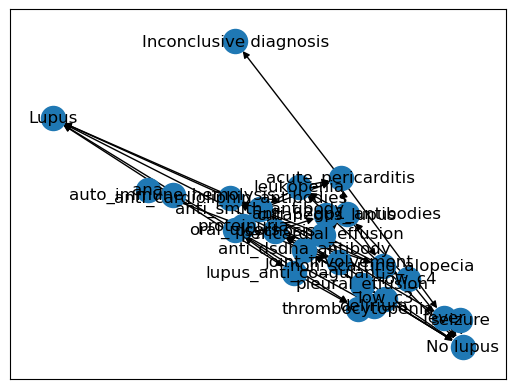

In [16]:
G = draw_networkx_graph(test_df)

#### Pyvis

In [17]:
net = Network('500px', directed=True, notebook=True, cdn_resources='in_line')
net.from_nx(G)
net.show('example.html')

In [18]:
pathways_df = create_sankey_df(test_df)
pathways_df['type'] = 'directed'
start_node = pathways_df.iloc[0]['source']
all_nodes = list(set(pathways_df.source.unique().tolist() + pathways_df.target.unique().tolist()))
terminal_nodes = list(set(pathways_df[pathways_df.link_type=='terminal'].target))
non_terminal_nodes = [i for i in all_nodes if i not in terminal_nodes and i!=start_node]
# pathways_df.head()

In [19]:
got_net = Network(notebook=True, height='750px', width='100%', directed=True, cdn_resources='in_line')
got_net.add_node(start_node, color='purple', size=20)
got_net.add_nodes(non_terminal_nodes, size=[15]*len(non_terminal_nodes), color=['blue']*len(non_terminal_nodes))
got_net.add_nodes(terminal_nodes, color=['green']*len(terminal_nodes), size=[20]*len(terminal_nodes)) #labelHighlightBold=[True]*len(terminal_nodes))

for src, target, value in zip(pathways_df.source, pathways_df.target, pathways_df.value):
    if value > threshold:
        got_net.add_edge(src, target, value=value, color='red')
    else:
        got_net.add_edge(src, target, value=value, color='blue')
    
got_net.show('Example.html')

#### Sankey diagram

In [159]:
# draw_sankey_diagram_orig(test_df, 'Target pathways', save=True, filename='../pathways/noisiness/0.4')

#### Just trying more stuff

In [93]:
got_net = Network(notebook=True, height='750px', width='100%', directed=True, cdn_resources='in_line')

# net = Network('500px', directed=True, notebook=True, cdn_resources='in_line')
# net.from_nx(G)
# net.show('example.html')

# set the physics layout of the network
got_net.barnes_hut()

sources = pathways_df['source']
targets = pathways_df['target']
values = pathways_df['value']
types = pathways_df['link_type']



got.add_nodes([1, 2, 3], size=[2, 4, 6], title=["n1", "n2", "n3"])

# create graph using pviz network 
edge_data = zip(sources, targets, values, types)

for src, dst, val, link_type in edge_data:
    if link_type == 'non_terminal':
        got_net.add_node(dst, label=dst, title=dst, color='green')
    else:
    got_net.add_node(src, label=src, title=src, color='blue')
#     got_net.add_edge(src, dst, value=val)
#     if link_type == 'terminal':
#         got_net.add_node(dst, label=dst, title=dst, color='green')
#     else:
#         got_net.add_node(dst, dst, title=dst, color='blue')

#     got_net.add_edge(src, dst, value=val)
got_net.show('Example.html')

AssertionError: non existent node 'joint_involvement'

In [17]:
import nxviz as nv                 # network viz
from nxviz import annotate 

/home/lmuyama/anaconda3/envs/stable_baselines_3_env/lib/python3.7/site-packages/nxviz/__init__.py:29: UserWarning:


nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)




In [18]:
trial_df = create_sankey_df(test_df)
trial_df.head()

,source,target,value,link_type
0,cutaneous_lupus,low_c4,13929,non_terminal
1,low_c4,anti_dsdna_antibody,13813,non_terminal
2,anti_dsdna_antibody,pericardial_effusion,13599,non_terminal
3,pericardial_effusion,ana,13542,non_terminal
4,ana,thrombocytopenia,13524,non_terminal


In [19]:
trial_df.source.unique()

array(['cutaneous_lupus', 'low_c4', 'anti_dsdna_antibody',
       'pericardial_effusion', 'ana', 'thrombocytopenia', 'leukopenia',
       'fever', 'oral_ulcers', 'delirium', 'lupus_anti_coagulant',
       'joint_involvement', 'proteinuria', 'pleural_effusion',
       'acute_pericarditis', 'seizure', 'non_scarring_alopecia',
       'anti_β2gp1_antibodies', 'low_c3', 'auto_immune_hemolysis',
       'psychosis', 'anti_cardioliphin_antibodies', 'anti_smith_antibody'],
      dtype=object)

In [20]:
attributes = pd.DataFrame([{'Label':'fever','Domain':'constitutional'}, 
                           {'Label':'leukopenia','Domain':'hematalogic'},
                           {'Label':'thrombocytopenia','Domain':'hematalogic'}, 
                           {'Label':'auto_immune_hemolysis','Domain':'hematalogic'},
                           {'Label':'delirium','Domain':'neuropsychiatric'}, 
                           {'Label':'psychosis','Domain':'neuropsychiatric'},
                           {'Label':'seizure','Domain':'neuropsychiatric'},
                           {'Label':'non_scarring_alopecia','Domain':'mucocutaneous'},
                           {'Label':'oral_ulcers','Domain':'mucocutaneous'},
                           {'Label':'cutaneous_lupus','Domain':'mucocutaneous'},
                           {'Label':'pleural_effusion','Domain':'serosal'},
                           {'Label':'pericardial_effusion','Domain':'serosal'},
                           {'Label':'acute_pericarditis','Domain':'serosal'},
                           {'Label':'joint_involvement','Domain':'musculoskeletal'},
                           {'Label':'proteinuria','Domain':'renal'},
                           {'Label':'anti_cardioliphin_antibodies','Domain':'antiphospholipid_antibodies'},
                           {'Label':'anti_β2gp1_antibodies','Domain':'antiphospholipid_antibodies'},
                           {'Label':'lupus_anti_coagulant','Domain':'antiphospholipid_antibodies'},
                           {'Label':'low_c3','Domain':'complement_proteins'},
                           {'Label':'low_c4','Domain':'complement_proteins'},
                           {'Label':'anti_smith_antibody','Domain':'sle_specific_antibodies'},
                           {'Label':'anti_dsdna_antibody','Domain':'sle_specific_antibodies'},
                           {'Label':'ana','Domain':'its own'}])
attributes.head()

,Label,Domain
0,fever,constitutional
1,leukopenia,hematalogic
2,thrombocytopenia,hematalogic
3,auto_immune_hemolysis,hematalogic
4,delirium,neuropsychiatric


In [21]:
len(attributes)

23

In [22]:
attributes['Domain'] = ['constitutional']*12 + ['hematalogic']*11
attributes.head()

,Label,Domain
0,fever,constitutional
1,leukopenia,constitutional
2,thrombocytopenia,constitutional
3,auto_immune_hemolysis,constitutional
4,delirium,constitutional


In [23]:
G = nx.from_pandas_edgelist(trial_df, source='source', target='target',edge_attr='value')
node_attr = attributes.set_index('Label').to_dict('index')
nx.set_node_attributes(G, node_attr)

TypeError: '<' not supported between instances of 'float' and 'str'

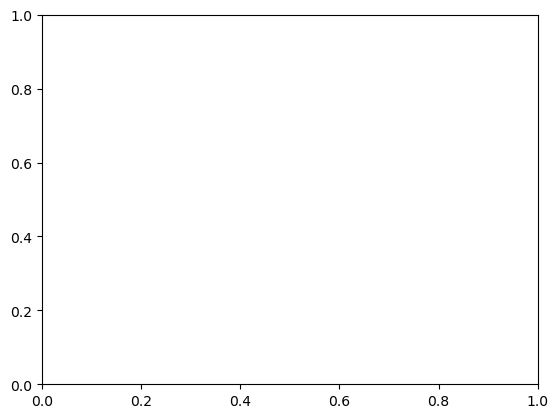

In [24]:
nv.hive(G, group_by='Domain')#, sort_by='Domain',node_color_by='Domain')
# annotate.node_colormapping(G, color_by='Domain')
plt.show()

In [ ]:
# target_df['trajectory'] = target_df['trajectory'].apply(lambda row: ast.literal_eval(row))
# target_df.head()

In [ ]:
type(target_df.iloc[0].trajectory)

In [ ]:
frequency_dict

In [ ]:
# def get_dict(path_set, target_list):
#     for path_dict in target_list:
#         if path_dict['set'] == path_set:
#             path_dict['value'] += path_set['value']
#             return path_dict

In [ ]:
frequency_dict_list = [] #will hold dictonaries with 2 keys i.e. 'set' and 'value'
count = 0
for path_dict, value in frequency_dict.items():
    all_set_list = [i['set'] for i in frequency_dict_list] #get all the sets so far in the list 
    path_set = set(ast.literal_eval(path_dict)) #get the set of current path dict to check if its already in list
    if path_set in all_set_list: #increase value else insert it - work on this!!!!!!!!!!!!!!!
        for elem in frequency_dict_list: #look for if path_set is already in frequency_dict_list 
            if elem['set'] == path_set: #find the matching path_set in the frequency_dict_list
                elem['value'] += value #increase the value for that set
    else:
        frequency_dict_list.append({'set':path_set, 'value':value})
frequency_dict_list[0]

In [ ]:
all_list = [list(path_dict['set']) for path_dict in frequency_dict_list]
flat_list = [item for sublist in all_list for item in sublist]
commonest_elements = dict(collections.Counter(flat_list))
commonest_elements = {k: v for k, v in sorted(commonest_elements.items(), reverse=True, key=lambda item: item[1])}
commonest_elements_list = list(commonest_elements.keys())
commonest_elements_list = [i for i in commonest_elements_list if i not in ['Lupus', 'No lupus']] + ['Lupus', 'No lupus']
commonest_elements_list

In [ ]:
for item in frequency_dict_list:
    item['set'] = sorted(list(item['set']), key=lambda x: commonest_elements_list.index(x))
frequency_dict_list[0]

In [ ]:
keys = [str(i['set']) for i in frequency_dict_list]
values = [i['value'] for i in frequency_dict_list]
final_frequency_dict = {k:v for (k,v) in zip(keys, values)}
final_frequency_dict

#### delete from here

In [ ]:
frequency_dict = {}
for traj in target_df.trajectory:
    if traj in frequency_dict.keys():
        frequency_dict[traj] += 1
    else:
        frequency_dict[traj] = 1
frequency_dict

#### end here

In [ ]:
frequency_dict_list = []
all_set_list = [i['set'] for i in frequency_dict_list]
all_set_list

In [ ]:
test_df[test_df.episode_length==8].trajectory.value_counts()

In [ ]:
overall_tup_dict = generate_tuple_dict(test_df)
overall_tup_dict

In [ ]:
pathways_df = utils.create_sankey_df(test_df)
pathways_df.head()